# ABSEHRD package demo
This notebook demonstrates Automated Brewering Synthetic Electronic Health Record Data (ABSEHRD) package functionality on a toy dataset.

## Setup

### Import python and ABSEHRD modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from preprocessor import Preprocessor
from corgan import Corgan
from realism import Realism
from privacy import Privacy

### Set parameters for the toy dataset and demo

In [2]:
# toy dataset
n = 10000
count_min = 5
count_max = 19
constant_value = 'helloworld'
binary_A = 'A'
binary_B = 'B'
categorical_values = ['X','Y','Z']
missing_value = -99999

# synthetic data generation and validation
n_gen = round(n/2)
outcome = 'binary01'

# sehrd objects
pre = Preprocessor(missing_value=missing_value)
rea = Realism()
pri = Privacy()
cor = Corgan()

### Generate the toy dataset

In [3]:
names = np.array(['constant','binary01', 'binaryAB', 'categorical','count','continuous'])
v_constant = np.full(shape=n, fill_value=constant_value)
v_binary01 = np.random.randint(low=0, high=2, size=n)
v_binaryAB = np.concatenate((np.full(shape=n-1, fill_value=binary_A), np.array([binary_B])))
v_categorical = np.random.choice(categorical_values, size=n)
v_count = np.random.randint(low=count_min, high=count_max+1, size=n)
v_continuous = np.random.random(size=n)
x = np.column_stack((v_constant, v_binary01, v_binaryAB, v_categorical, v_count, v_continuous))
print(x)

[['helloworld' '1' 'A' 'Y' '12' '0.7317781515496745']
 ['helloworld' '0' 'A' 'X' '16' '0.9794422279910169']
 ['helloworld' '1' 'A' 'Y' '18' '0.6417232527330562']
 ...
 ['helloworld' '1' 'A' 'X' '19' '0.9780923569515035']
 ['helloworld' '1' 'A' 'Z' '9' '0.1635696835514']
 ['helloworld' '0' 'B' 'Y' '7' '0.2829641883829115']]


### Split into training and testing set

In [4]:
n_subset = round(len(x) * 0.5)
idx_trn = np.random.choice(len(x), n_subset, replace=False)
idx_tst = np.setdiff1d(range(len(x)), idx_trn)
x_trn = x[idx_trn,:]
x_tst = x[idx_tst,:]

print('Number of training samples: '+str(len(x_trn)))
print('Number of testing samples: '+str(len(x_tst)))

Number of training samples: 5000
Number of testing samples: 5000


## Preprocessing

### Save metadata for restoring data format after synthetic data generation

In [5]:
meta = pre.get_metadata(arr=x_trn, header=names)
print('var_name, var_type, min, max, zero, one, unique, missing')
print(meta)

var_name, var_type, min, max, zero, one, unique, missing
[('constant', 'constant', 0.00000000e+00,  0.        , 'helloworld', '', '', False)
 ('binary01', 'binary', 0.00000000e+00,  0.        , '1', '0', '', False)
 ('binaryAB', 'constant', 0.00000000e+00,  0.        , 'A', '', '', False)
 ('categorical', 'categorical', 0.00000000e+00,  0.        , '', '', 'X,Y,Z', False)
 ('count', 'count', 5.00000000e+00, 19.        , '', '', '', False)
 ('continuous', 'continuous', 4.54523107e-05,  0.99998103, '', '', '', False)]


### Encode raw data matrix in preparation for training synthetic data generator
Note that count and continuous variables have been scaled between 0 and 1 while constant, categorical, and binary have been one-hot encoded.

In [6]:
d_trn = pre.get_discretized_matrix(x_trn, meta, names)
print('Formatted matrix:')
print(d_trn['x'])
print('\nHeader for formatted matrix:')
print(d_trn['header'])

Formatted matrix:
[[0.         0.         0.         ... 0.         0.26803333 0.        ]
 [0.         0.         1.         ... 0.         0.4587881  0.        ]
 [0.         0.         1.         ... 0.         0.63881816 0.        ]
 ...
 [0.         0.         1.         ... 0.         0.28533501 0.        ]
 [0.         0.         0.         ... 0.         0.3306033  0.        ]
 [0.         0.         1.         ... 0.         0.25196531 0.        ]]

Header for formatted matrix:
['constant__constant' 'constant__-99999' 'binary01__binary01'
 'binary01__-99999' 'binaryAB__binaryAB' 'binaryAB__-99999'
 'categorical__0' 'categorical__1' 'categorical__2' 'categorical__3'
 'count__count' 'count__-99999' 'continuous__continuous'
 'continuous__-99999']


## Generation

### Train CorGAN model 

In [7]:
model = cor.train(x=d_trn['x'], n_cpu=1, debug=True, n_epochs_pretrain=100, n_epochs=100)

Training: 100%|██████████| 100/100 [00:42<00:00,  2.33 epochs/s, TRAIN: [Loss_D: -0.015] [Loss_G: 0.010] [Loss_D_real: 0.016] [Loss_D_fake 0.001] | TEST: [A loss: 1.01] [real accuracy: 81.05] [fake accuracy: 50.59]]  


### Generate synthetic samples

In [8]:
s = cor.generate(model, n_gen)
print(s)

[[5.43743779e-04 1.25423062e-03 2.62064487e-02 ... 7.50753505e-04
  9.69248593e-01 9.56930511e-04]
 [5.55489212e-04 4.51178348e-04 7.70015836e-01 ... 1.20559020e-03
  9.90430653e-01 2.42029107e-03]
 [1.90210470e-03 6.73695933e-04 6.54788673e-01 ... 1.00653386e-03
  9.98320878e-01 6.66111009e-04]
 ...
 [2.11978843e-03 1.01520086e-03 8.26494217e-01 ... 1.20688858e-03
  9.98682797e-01 5.97831735e-04]
 [4.77341702e-04 1.21426747e-04 7.91841865e-01 ... 1.45728991e-03
  2.27604598e-01 3.13907483e-04]
 [3.34599667e-04 2.37220898e-03 9.99521971e-01 ... 1.05617603e-03
  1.34553611e-01 1.98602490e-03]]


### Use metadata to restore original formatting

In [9]:
f = pre.restore_matrix(arr=s, meta=meta, header=d_trn['header'])
print('Synthetic samples:')
print(f['x'])
print('\nReal samples:')
print(x)

Synthetic samples:
[['helloworld' '1' 'A' 'Y' '5.0' '0.9692316085035941']
 ['helloworld' '0' 'A' 'X' '6.0' '0.9904123042479744']
 ['helloworld' '0' 'A' 'Y' '5.0' '0.9983020204355']
 ...
 ['helloworld' '0' 'A' 'Z' '5.0' '0.9986639165245996']
 ['helloworld' '0' 'A' 'X' '14.0' '0.22763538837742045']
 ['helloworld' '0' 'A' 'Y' '11.0' '0.13459039596952926']]

Real samples:
[['helloworld' '1' 'A' 'Y' '12' '0.7317781515496745']
 ['helloworld' '0' 'A' 'X' '16' '0.9794422279910169']
 ['helloworld' '1' 'A' 'Y' '18' '0.6417232527330562']
 ...
 ['helloworld' '1' 'A' 'X' '19' '0.9780923569515035']
 ['helloworld' '1' 'A' 'Z' '9' '0.1635696835514']
 ['helloworld' '0' 'B' 'Y' '7' '0.2829641883829115']]


## Realism

### Compare univariate frequency for real and synthetic features


Summary of feature_frequency:
  > Frequency correlation (train): 0.99
  > Frequency correlation (test): 1.0


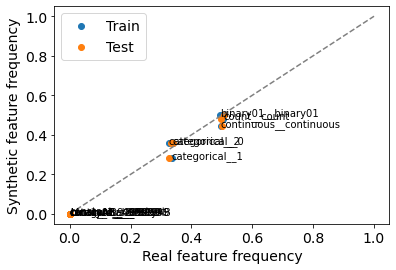

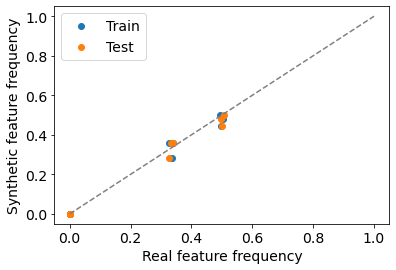

In [10]:
res_frq = rea.feature_frequency(mat_f_r_trn=x_trn, 
                                mat_f_r_tst=x_tst, 
                                mat_f_s=f['x'], 
                                header=names, 
                                missing_value=missing_value)
print(rea.summarize(res_frq, analysis='feature_frequency'))
res_plt = rea.plot(res_frq, analysis='feature_frequency', labels_on=True)
res_plt = rea.plot(res_frq, analysis='feature_frequency', labels_on=False)

### Compare effect sizes
Compare effect sizes from a train logistic regression method for a binary outcome between a model trained from real data and synthetic data.


Summary of feature_effect:
  > Importance correlation (train): -0.0
  > Importance correlation (test): 0.04


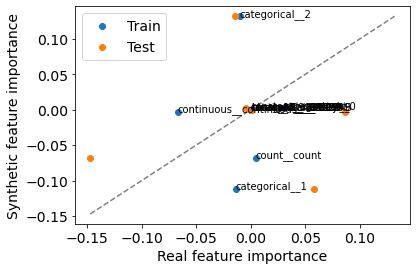

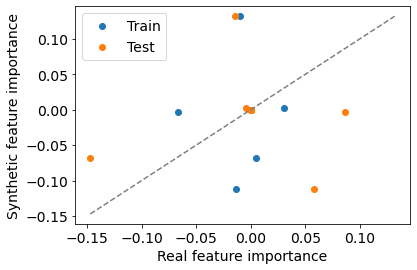

True

In [11]:
res_effect = rea.feature_effect(mat_f_r_trn=x_trn, 
                                mat_f_r_tst=x_tst, 
                                mat_f_s=f['x'], 
                                header=names, 
                                outcome=outcome, 
                                missing_value=missing_value, 
                                scaled=False)
print(rea.summarize(res_effect, analysis='feature_effect'))
rea.plot(res_effect, analysis='feature_effect', labels_on=True)
rea.plot(res_effect, analysis='feature_effect', labels_on=False)

### Compare predictive performance
* Real: use real dataset to train predictive model and test on a separate real dataset
* GAN-train: use synthetic dataset to train predictive model and test on a real dataset
*GAN-test: use real dataset to train predictive model and test on the synthetic dataset

In [12]:
print('Train models to predict outcome \'', outcome,'\' from real and synthetic datasets', sep='')

Train models to predict outcome 'binary01' from real and synthetic datasets



Summary of gan_train_test:
  > Real AUC: 0.51
  > GAN-train AUC: 0.49
  > GAN-test AUC: 0.5


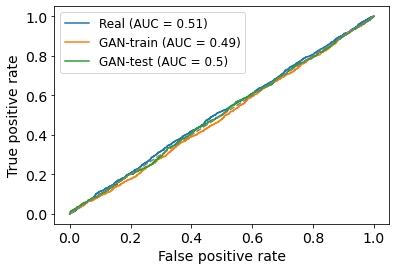

In [21]:
res_gan = rea.gan_train_test(mat_f_r_trn=x_trn, 
                                mat_f_r_tst=x_tst, 
                                mat_f_s=f['x'], 
                                header=names, 
                                outcome=outcome, 
                                missing_value=missing_value, 
                                n_epoch=100, 
                                model_type='mlp')
print(rea.summarize(res_gan, analysis='gan_train_test'))
res_plt = rea.plot(res_gan, analysis='gan_train_test')

## Privacy

## Nearest neighbors
Ensure that synthetic dataset is not a copy of the real dataset by comparing distances between pairs of real and synthetic samples
* Real-real: distance between randomly selected pairs of real samples
* Real-synthetic: distance between pairs of real and synthetic samples
* Real-probabilistic: distance between a real sample and sampled binary vector where each column is sampled from a binomial where the frequency equals that in the real training set
* Real-random: distance between a real sample and a randomly sampled binary vector

Calculate nearest neighbor distributions:

In [17]:
n_nn_sample = 100
dist_metric = 'euclidean'
n_decimal=2

idx_r = np.random.randint(low=0, high=len(r), size=min((len(r), n_nn_sample)))
idx_s = np.random.randint(low=0, high=len(s), size=min((len(s), n_nn_sample)))
res_nn = pri.assess_memorization(r[idx_r,:], s[idx_s,:], metric=dist_metric)

Summarize and plot distributions for nearest neighbor distances:


Summary of nearest_neighbors:
Mean nearest neighbor distance: 
  > Real-real: 0.14
  > Real-synthetic: 0.3
  > Real-probabilistic: 0.44
  > Real-random: 1.42


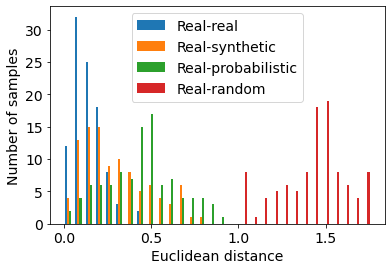

In [18]:
print(pri.summarize(res_nn, analysis='nearest_neighbors'))
res_plt = pri.plot(res_nn, analysis='nearest_neighbors')

## Membership inference
Membership inference refers to the ability to determine if a given data sample was used to train a model of interest.  In the case of synthetic data, calculating the risk of accurate membership inference given a sample of synthetic data can provide a metric to assess risk to privacy of the synthetic dataset to individuals whose data was used to train the synthetic data generator.  

Risk of membership inference can be assessed in multiple scenarios with differing assumptions about what data is available to the attacker.

### Distance-based thresholding
Choi et al. (2017) and Torfi et al. (2020) calculated the distance between synthetic and real samples. Real samples were derived from the training dataset for the synthetic data generator and from a separate testing set.  Pairwise distances between synthetic and real samples were predicted as a match if the distance was within a specified threshold.  Predictions and labels were then compared to derived performance metrics for the membership inference attack. 

In [19]:
d_tst = pre.get_discretized_matrix(x_tst, meta, names)
mi_torfi = pri.membership_inference(r_trn=d_trn['x'], r_tst=d_tst['x'], s_all=s, mi_type='torfi', n_cpu=1)


Summary of membership_inference:
AUC for attack: 0.49


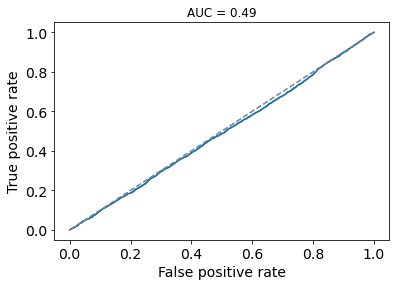

True

In [20]:
print(pri.summarize(res=mi_torfi, analysis='membership_inference'))
pri.plot(res=mi_torfi, analysis='membership_inference')